# HSE 2023: Mathematical Methods for Data Analysis

## Seminar 13: Introduction to Deep Learning




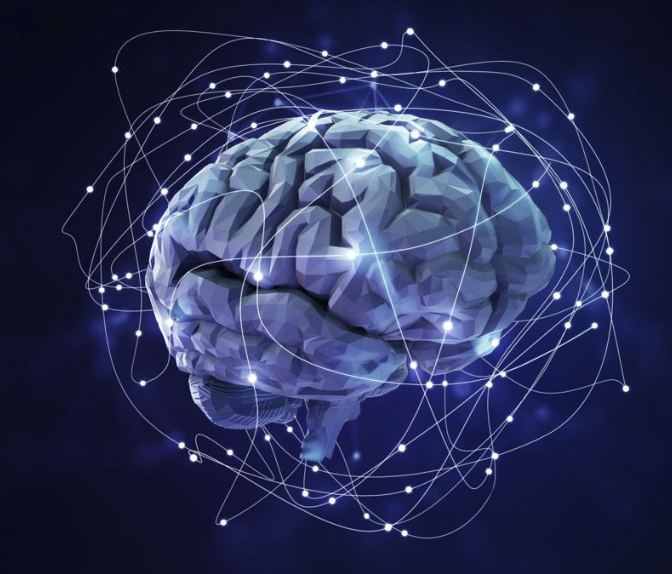

In this seminar, we're going to dive deep into Deep Learning! Finally, Neural Networks!

## Plan for taday

**Part 1** Neural network from skretch

**Part 2** PyTorch

## Part 1 Neural Network from skretch

In this part we are going to build our own neural network from skretch using numpy and train it on MNIST task.

This part of the notebook is based on the [seminar](https://github.com/yandexdataschool/Practical_DL/blob/fall22/week01_backprop/backprop.ipynb) from Practical DL course.

### Download the data

In [ ]:
# if running in colab, uncomment this:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/35c067adcc1ab364c8803830cdb34d0d50eea37e/week01_backprop/util.py -O util.py
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/35c067adcc1ab364c8803830cdb34d0d50eea37e/week01_backprop/mnist.py -O mnist.py
from __future__ import print_function
import numpy as np
np.random.seed(42)

--2023-12-10 23:01:02--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/35c067adcc1ab364c8803830cdb34d0d50eea37e/week01_backprop/util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3782 (3.7K) [text/plain]
Saving to: ‘util.py’

util.py             100%[===================>]   3.69K  --.-KB/s    in 0s      

2023-12-10 23:01:02 (29.3 MB/s) - ‘util.py’ saved [3782/3782]

--2023-12-10 23:01:02--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/35c067adcc1ab364c8803830cdb34d0d50eea37e/week01_backprop/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connec

Here goes our main class: a layer that can `.forward()` and `.backward()`.

In [ ]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)

    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.

        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):

        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.

        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]

        d_layer_d_input = np.eye(num_units)

        return np.dot(grad_output, d_layer_d_input) # chain rule

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=X \cdot W + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

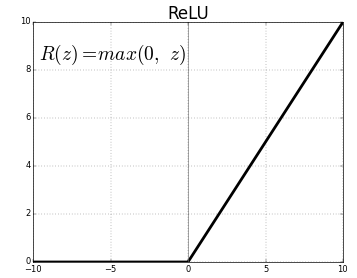

In [ ]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass

    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # WARNING! output = np.max(0, input) is NOT correct
        output = np.maximum(0, input)
        return output

    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output * relu_grad

In [ ]:
# some tests
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

#### Instant primer: lambda functions

In python, you can define functions in one line using the `lambda` syntax: `lambda param1, param2: expression`

For example: `f = lambda x, y: x+y` is equivalent to a normal function:

```
def f(x,y):
    return x+y
```
For more information, click [here](http://www.secnetix.de/olli/Python/lambda_functions.hawk).    

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= X \cdot W + \vec b $$

Where
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs]
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [ ]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <x*W> + b
        """
        self.learning_rate = learning_rate

        # initialize weights with small random numbers. We use normal initialization,
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)

    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <x*W> + b

        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases#<your code here>

    def backward(self,input,grad_output):

        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T) #<your code here>

        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T,  grad_output) #<your code here>
        grad_biases = np.dot(np.ones(grad_output.shape[0]), grad_output) #<your code here>

        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step.
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

### Testing the dense layer

Here we have a few tests to make sure your dense layer works properly. You can just run them, get 3 "well done"s and forget they ever existed.

... or not get 3 "well done"s and go fix stuff. If that is the case, here are some tips for you:
* Make sure you compute gradients for b as __sum of gradients over batch__, not mean over gradients. Grad_output is already divided by batch size.
* If you're debugging, try saving gradients in class fields, like "self.grad_w = grad_w" or print first 3-5 weights. This helps debugging.
* If nothing else helps, try ignoring tests and proceed to network training. If it trains alright, you may be off by something that does not affect network training.

In [ ]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [ ]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [ ]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)

def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases

w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, you'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive `log(softmax(a))` in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [ ]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]

    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)

    return (- ones_for_answers + softmax) / logits.shape[0]

In [ ]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

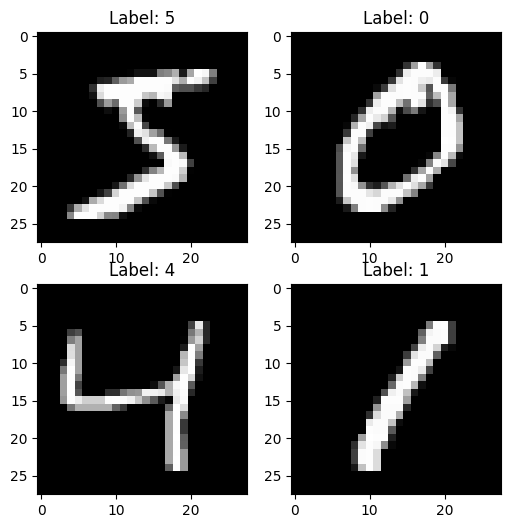

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [ ]:
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 200))
network.append(ReLU())
network.append(Dense(200, 10))

In [ ]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer.
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    # <your code here>
    for i, layer in enumerate(network):
        output = layer.forward(input)
        activations.append(output)
        input = output

    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

### Backprop

You can now define the backpropagation step for the neural network. Please read the docstring.

In [ ]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    You can estimate loss and loss_grad, obtaining dL / dy_pred
    Then you can run layer.backward going from last layer to first,
    propagating the gradient of input to previous layers.

    After you called backward for all layers, all Dense layers have already made one gradient step.
    """

    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]

    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)


    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    #<YOUR CODE>
    for i in range(len(network)):

        layer = network[-i-1]
        layer_input = layer_inputs[-i-2]

        loss_grad = layer.backward(layer_input, loss_grad)

    return np.mean(loss)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [ ]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [ ]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 24
Train accuracy: 0.99998
Val accuracy: 0.9803


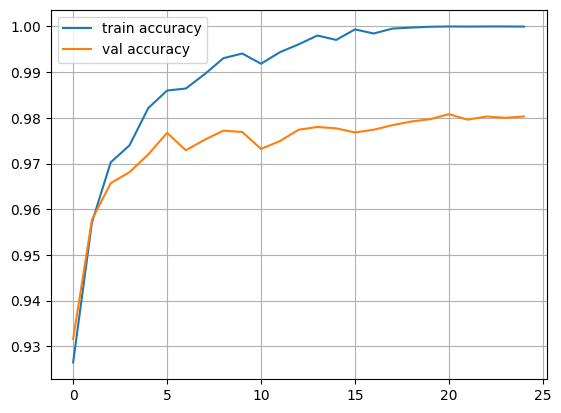

In [ ]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)

    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


__What should you see:__ `train accuracy` should increase to near-100%. Val accuracy will also increase, allbeit to a smaller value.



Good hunting!

## Part 2 Pytorch

In this part we are going to meet **PyTorch**. It looks similar to numpy with some small differences (actually it can do much more but today we are going to discuss them later) -- PyTorch can compute gradients for you, which makes in unnecessary to write backprop for neural networks yourself.

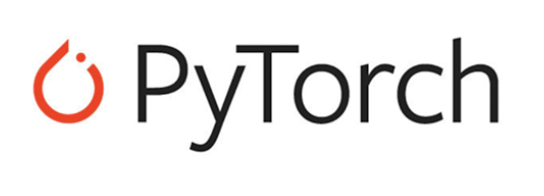

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from tqdm.notebook import tqdm

%matplotlib inline

#### In this part we will:

1. Compare numpy and PyTorch
2. Train our very first neural network

### 1. Creating tensors in PyTorch

In [ ]:
x = torch.empty(5, 3)  # empty tensor
print(x)

tensor([[1.5766e-19, 1.0256e-08, 1.0313e-08],
        [3.0270e+12, 6.7739e-10, 6.5650e-07],
        [6.7501e-07, 1.2680e+16, 2.1707e-18],
        [7.0952e+22, 1.7748e+28, 1.8176e+31],
        [7.2708e+31, 5.0778e+31, 3.2608e-12]])


In [ ]:
x = torch.rand(5, 3)  # random tensor
print(x)

tensor([[0.2131, 0.5444, 0.8533],
        [0.9886, 0.7487, 0.2680],
        [0.5334, 0.6096, 0.7335],
        [0.7510, 0.2127, 0.8185],
        [0.1087, 0.5946, 0.8894]])


In [ ]:
x = torch.zeros(5, 3, dtype=torch.float32)  # tensor filled with zeros and with the specified data type
print(x)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [ ]:
x = torch.tensor([5.5, 3])  # construct a tensor from python list
print(x)

tensor([5.5000, 3.0000])


In [ ]:
x1 = x.new_ones(5, 3, dtype=torch.double)  # create tensor filled with ones from existing tensor (to transfer device and dtype of the source one)
print(x, x.size())

tensor([5.5000, 3.0000]) torch.Size([2])


In [ ]:
x = torch.randn_like(x1, dtype=torch.float)  # create random tensor with the shape of another tensor
print(x, x.size())

tensor([[-0.1798, -0.3941,  1.4479],
        [-1.2451, -0.1074, -1.2800],
        [-0.0435,  1.7440,  0.0894],
        [ 0.4828, -0.3437,  2.1813],
        [ 0.8197, -0.0614, -0.0942]]) torch.Size([5, 3])


In [ ]:
y = torch.rand(5, 3)
print(x + y)  # Addition

tensor([[ 0.0284,  0.4632,  1.7298],
        [-0.9974,  0.7262, -0.8137],
        [ 0.0500,  2.7298,  0.2114],
        [ 1.2507,  0.0831,  2.4918],
        [ 1.5425,  0.6337,  0.1982]])


In [ ]:
z = torch.add(x, y)  # Multiplication
print(z)

tensor([[ 0.0284,  0.4632,  1.7298],
        [-0.9974,  0.7262, -0.8137],
        [ 0.0500,  2.7298,  0.2114],
        [ 1.2507,  0.0831,  2.4918],
        [ 1.5425,  0.6337,  0.1982]])


In [ ]:
torch.add(x, y, out=z)  # another syntax
print(z)

tensor([[ 0.0284,  0.4632,  1.7298],
        [-0.9974,  0.7262, -0.8137],
        [ 0.0500,  2.7298,  0.2114],
        [ 1.2507,  0.0831,  2.4918],
        [ 1.5425,  0.6337,  0.1982]])


In [ ]:
print(x * y)  # element-wise multiplication

tensor([[-0.0374, -0.3379,  0.4082],
        [-0.3085, -0.0895, -0.5969],
        [-0.0041,  1.7192,  0.0109],
        [ 0.3707, -0.1467,  0.6773],
        [ 0.5925, -0.0427, -0.0275]])


In [ ]:
print(x @ y.t())  # matrix multiplication

tensor([[ 0.0329,  0.3021, -0.2287,  0.1433,  0.0194],
        [-0.7122, -0.9949, -0.3784, -1.3994, -1.3489],
        [ 1.5113,  1.4847,  1.7260,  0.7388,  1.2070],
        [ 0.4208,  0.8503, -0.0276,  0.9013,  0.7478],
        [ 0.0914,  0.1080,  0.0046,  0.5739,  0.5223]])


In [ ]:
print(x.mm(y.t()))  # and another matrix multiplication

tensor([[ 0.0329,  0.3021, -0.2287,  0.1433,  0.0194],
        [-0.7122, -0.9949, -0.3784, -1.3994, -1.3489],
        [ 1.5113,  1.4847,  1.7260,  0.7388,  1.2070],
        [ 0.4208,  0.8503, -0.0276,  0.9013,  0.7478],
        [ 0.0914,  0.1080,  0.0046,  0.5739,  0.5223]])


In [ ]:
print(x.unsqueeze(0).shape)  # added a new dimension before existing ones, broadcasting alternative

torch.Size([1, 5, 3])


In [ ]:
print(x.unsqueeze(0).unsqueeze(1).squeeze().shape)  # removed all dimensions of size 1

torch.Size([5, 3])


### 2. Our very first neural network

In order to understand how train neural networks in PyTorch you need to know three things:

1. How to form batches and put them into the network
2. How to make the network
3. How to write a training loop and track metrics

#### How to form batches and put them in the NN

In order to be able to iterate over the dataset you need to create a class inherited from `torch.utils.data.Dataset`.

An example from documentation:

```
class FaceLandmarksDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample
```

As you may see, the class **must** have two neccessary methods:

* `__len__` -- returns information about the amount of objects in dataset
* `__getitem__` -- returns an item and its target (if you need it)


Now let's write such a class ourselves which forms a dataset of random data.

In [ ]:
class RandomDataset(torch.utils.data.Dataset):
    """
    Our random dataset
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {"sample": torch.tensor(x[idx, :], dtype=torch.float), "target": y[idx]}

In [ ]:
x = np.random.rand(1000, 5)
y = np.random.rand(1000)

In [ ]:
our_dataset = RandomDataset(x, y)

In [ ]:
our_dataset.__getitem__(1)

{'sample': tensor([0.5526, 0.1396, 0.9865, 0.2091, 0.2741]),
 'target': 0.22611663240175084}

In order to form batches from the dataset in PyTorch there exists a DataLoader class which takes as an input objects of classes inherited from `torch.utils.data.Dataset` (as the one we made earlier).

Let's look at an example:

In [ ]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=4)

We work with it the following way:

In [ ]:
batch = next(iter(dataloader))

print(f"Sample:\n{batch['sample']}")
print(f"Target:\n{batch['target']}")

Sample:
tensor([[0.2085, 0.6237, 0.3738, 0.1055, 0.8596],
        [0.5526, 0.1396, 0.9865, 0.2091, 0.2741],
        [0.0372, 0.2357, 0.6308, 0.1503, 0.5510],
        [0.7745, 0.0532, 0.7298, 0.7369, 0.1156]])
Target:
tensor([0.2240, 0.2261, 0.4276, 0.4335], dtype=torch.float64)


#### Writing a neural network from skratch

In order to create neural networks in high-level PyTorch we use `nn` module. A neural network needs to be inherited from the class `nn.Module`.

Below is an example how it can look like:

```
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
       x = F.relu(self.conv1(x))
       return F.relu(self.conv2(x))
```

As we can see, the class **must** have a method `forward` which represents forward pass of the neural network. Also we can see that `nn` module has implementations of many layers and `nn.functional` has implementation of many activation functions.

Below is another way to form a neural network.

In [ ]:
model = nn.Sequential()                   # create a simple sequential model which we'll be adding layers in
model.add_module("l1", nn.Linear(5, 10))  # add layer with 5 neurons on input and 10 neurons on output
model.add_module("l2", nn.ReLU())         # add activation function
model.add_module("l3", nn.Linear(10, 1))  # add layer with 10 neurons on input and 1 neuron on output

# alternative way (through the constuctor)
another_model = nn.Sequential(
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

In [ ]:
y_pred = model(batch['sample']) # get model predictions

### Additional materials:

**Warning:** some of them are in Russian.

* [PyTroch на простейшем примере с пояснениями](https://github.com/Kaixhin/grokking-pytorch)
* [Pytorch за 60 минут](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [Как устроено автоматическое дифференцирование в pytorch](http://videolectures.net/site/normal_dl/tag=1129745/deeplearning2017_johnson_automatic_differentiation_01.pdf)